## FEATURES

* dataset mas grande (2000 datos)
* Mas variables (piscina, parrillero, año de construcción, etc.)

In [1]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder = '/content/drive/MyDrive/MaestriaDataScience/Tesis/dataset_definitivo_merged.xlsx'

In [4]:
import pandas as pd

data = pd.read_excel(folder)

In [5]:
data.head()

,Unnamed: 0,url,precio,Baños,Superficie,Superficie Construida,Superficie Terreno,Garage,Calefacción,Cocina,Año de Construcción,Jardín,Piscina,Plantas,Parrillero,Acepta Mascotas,Patio,Dormitorio,barrio,municipio
0,0,https://www.casasymas.com.uy/propiedad/222586-...,580000,3.0,586.0,195.0,586.0,1,0,Cocina Definida,1960,1,0,NaN,0,NaN,0,5.0,punta-gorda,E
1,1,https://www.casasymas.com.uy/propiedad/186603-...,675000,4.0,NaN,242.0,268.0,1,0,NaN,1951,1,0,3.0,1,NaN,0,4.0,parque-batlle,CH
2,2,https://www.casasymas.com.uy/propiedad/227830-...,298000,2.0,104.0,94.0,10.0,1,0,NaN,1930,0,0,NaN,0,Acepta Mascotas,0,3.0,punta-carretas,CH
3,3,https://www.casasymas.com.uy/propiedad/212637-...,148000,2.0,131.0,98.0,131.0,1,0,Cocina Integrada,1964,0,0,NaN,0,Acepta Mascotas,0,2.0,belvedere,A
4,4,https://www.casasymas.com.uy/propiedad/225135-...,625000,3.0,408.0,234.0,174.0,1,0,Cocina Definida,2025,1,0,NaN,0,Acepta Mascotas,0,4.0,carrasco,E


## Funciones Auxiliares

Para automatizar entrenamiento de modelos y ahorrar tiempo. Luego invocaremos las funciones para entrenar.

In [6]:
def split_data_log(df, features: list, target: list):
  X = features
  y = np.log(target)
  X = X.fillna(0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def split_data_with_preprocessing(
    df,
    target: str,
    num_cols: list,
    cat_cols: list,
    test_size: float = 0.20,
    val_size: float = 0.20,
    random_state: int = 42
):
    # Transformación logarítmica del target
    y = np.log(df[target])

    # Features sin target
    X = df[num_cols + cat_cols]

    # Primera división: train+val vs test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Segunda división: train vs val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=val_size,
        random_state=random_state
    )

    # Pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Combinación final
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ]
    )

    # Ajustar preprocess SOLO con training
    preprocess.fit(X_train)

    # Aplicar transformaciones
    X_train_prep = preprocess.transform(X_train)
    X_val_prep = preprocess.transform(X_val)
    X_test_prep = preprocess.transform(X_test)

    return (
        X_train_prep, X_val_prep, X_test_prep,
        y_train, y_val, y_test,
        preprocess,
        X_test.index
    )

In [8]:
def linear_regression_model(X_train, y_train):
  model_lr = LinearRegression()
  model_lr.fit(X_train, y_train)
  return model_lr

In [9]:
import lightgbm as lgb

def lightgbm_model(X_train, y_train, params=None):
    # Parámetros por defecto optimizados para MAE
    if params is None:
        params = {
            "objective": "l1",          # minimiza MAE
            "metric": "mae",           # evalúa usando MAE
            "learning_rate": 0.03,
            "num_leaves": 31,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5
        }

    train_data = lgb.Dataset(X_train, label=y_train)

    model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=500
    )

    return model


In [10]:
from xgboost import XGBRegressor

def train_xgboost(X_train, y_train):
    model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.01,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
  )

    model.fit(X_train, y_train)
    return model


In [11]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(
        n_estimators=600,          # más árboles mejora MAE
        max_depth=20,              # evita overfitting, mantiene estabilidad
        min_samples_split=5,       # suaviza los árboles
        min_samples_leaf=2,        # controla extremos, mejora MAE
        max_features="sqrt",       # buen balance bias-variance
        bootstrap=True,            # robusto
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)
    return rf


from sklearn.model_selection import GridSearchCV

def random_forest_grid_search(X_train, y_train, cv: int = 5, n_jobs: int = -1, verbose: int = 2):

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_grid = {
        'n_estimators': [200, 400, 600],        # número de árboles
        'max_depth': [None, 10, 20],            # profundidad máxima
        'min_samples_split': [2, 10, 20],       # min de muestras para dividir nodo
        'min_samples_leaf': [1, 5, 10],         # min de muestras por hoja
        'max_features': ['sqrt', 'log2', 0.8]   # nº de features consideradas por split
    }

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        n_jobs=n_jobs,
        scoring='neg_mean_absolute_error',
        verbose=verbose
    )

    grid_search.fit(X_train, y_train)

    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor score (CV MAE log):", grid_search.best_score_)

    return grid_search.best_estimator_

In [12]:
def lr_grid_search(X_train, y_train):

    # Definir el modelo base
    lr = LinearRegression()

    # Grilla de hiperparámetros
    param_grid = {
        'fit_intercept': [True, False],
        # 'normalize': [True, False]  # solo si usás sklearn < 1.0
    }

    # Configurar GridSearch
    grid_search = GridSearchCV(
        estimator=lr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    # Entrenar
    grid_search.fit(X_train, y_train)

    # Retornar el mejor modelo
    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor score (CV):", grid_search.best_score_)

    return grid_search.best_estimator_


In [13]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [14]:
def evaluation_table(model, X_test, y_test, original_df, extra_cols: list = None):

    # Predicciones
    y_pred_log = model.predict(X_test)
    y_pred_real = np.exp(y_pred_log)
    y_test_real = np.exp(y_test)

    # Crear DataFrame con errores
    results = pd.DataFrame({
        "Precio Real": y_test_real,
        "Precio Predicho": y_pred_real,
        "Error Absoluto": np.abs(y_test_real - y_pred_real),
        "Error %": 100 * np.abs((y_test_real - y_pred_real) / y_test_real)
    }, index=y_test.index)

    # Agregar columnas adicionales si existen en original_df
    if extra_cols:
        original_df = original_df.reset_index(drop=True)
        for col in extra_cols:
            if col in original_df.columns:
                results[col] = original_df[col].values[:len(results)]

    results = results.sort_values(by="Error %", ascending=False)

    return results.reset_index(drop=True)

In [15]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [16]:
def crear_tabla_resultados(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
    resultados = []

    for nombre, mse, r2, mae, medae, mape, mdape in zip(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
        resultados.append({
            "Modelo": nombre,
            "MAE": mae,
            "MEDAE": medae,
            "MSE": mse,
            "R2": r2,
            "MAPE": mape,
            "MDAPE": mdape
        })

    df_resultados = pd.DataFrame(resultados)
    pd.options.display.float_format = '{:,.2f}'.format
    return df_resultados


## Target y Features

In [17]:
features_simple = ["Baños", "Dormitorio", "Superficie", "Superficie Construida", "Superficie Terreno", "Garage", "Parrillero", "Calefacción", "Año de Construcción", "Jardín", "Piscina", "Patio"]



target = "precio"

## Train Test Splits

In [21]:
cat_cols = ["barrio", "municipio"]

(
    X_train_prep_all_municipios,
    X_val_prep_all_municipios,
    X_test_prep_all_municipios,
    y_train_all_municipios,
    y_val_all_municipios,
    y_test_all_municipios,
    preprocess_all_municipios,
    test_indices_all_municipios
) = split_data_with_preprocessing(
        df=data,
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,
        test_size=0.20,
        val_size=0.20,
        random_state=42
    )


In [22]:
data_ch = data[data["municipio"] == "CH"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_ch,
    X_val_prep_ch,
    X_test_prep_ch,
    y_train_ch,
    y_val_ch,
    y_test_ch,
    preprocess_ch,
    test_indices_ch
) = split_data_with_preprocessing(
        df=data_ch,             # ← ahora solo CH
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,      # podés incluir categóricas o dejarlas vacías
        test_size=0.20,
        val_size=0.20,
        random_state=42
    )


In [23]:
data_e = data[data["municipio"] == "E"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_e,
    X_val_prep_e,
    X_test_prep_e,
    y_train_e,
    y_val_e,
    y_test_e,
    preprocess_e,
    test_indices_e
) = split_data_with_preprocessing(
        df=data_e,             # ← ahora solo municipio E
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,
        test_size=0.20,
        val_size=0.20,
        random_state=42
    )


## Modelos

Entrenaremos modelos con features simples y features completas en todos los casos.

* Linear regression all_municipios
* RF municipio_ch
* RF municipio_e
* RF all_municipios
* RF Gridsearch municipio_ch
* RF Gridsearch municipio_e
* RF Gridsearch all_municipios

Nombres de modelos simples y completos:

* `model_lr_simple`, `model_lr`
* `rf_municipio_ch_simple`, `rf_municipio_ch`
* `rf_municipio_e_simple`, `rf_municipio_e`
* `rf_all_municipios_simple`, `rf_all_municipios`
* `rf_gridsearch_municipio_ch_simple`, `rf_gridsearch_municipio_ch`
* `rf_gridsearch_municipio_e_simple`, `rf_gridsearch_municipio_e`
* `rf_gridsearch_all_municipios_simple`, `rf_gridsearch_all_municipios`

## `xgb_simple`

In [24]:
xgb_simple = train_xgboost(
    X_train_prep_all_municipios,
    y_train_all_municipios
)

print("XGBoost simple entrenado:", xgb_simple)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [25]:
mse_xgb_simple, r2_xgb_simple, mae_xgb_simple, medae_xgb_simple, mape_xgb_simple, mdape_xgb_simple = evaluate_model(
    xgb_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (MSE): {mse_xgb_simple}")
print(f"R² Score: {r2_xgb_simple}")
print(f"Mean Absolute Error (MAE): {mae_xgb_simple}")
print(f"Median Absolute Error (XGB): {medae_xgb_simple}")
print(f"MAPE (XGB): {mape_xgb_simple}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_simple}")


Mean Squared Error (MSE): 28487546877.84377
R² Score: 0.7691056990335771
Mean Absolute Error (MAE): 91256.50149327531
Median Absolute Error (XGB): 41813.53125
MAPE (XGB): 23.94418977609486
Median Absolute Percentage Error (XGB): 16.48766304347817


## `model_lgbm_simple` (all municipios)

In [26]:
model_lgbm_simple = lightgbm_model(
    X_train_prep_all_municipios,
    y_train_all_municipios
)

print("Modelo LightGBM entrenado:", model_lgbm_simple)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 1263, number of used features: 38
[LightGBM] [Info] Start training from score 12.542545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Modelo LightGBM entrenado: <lightgbm.basic.Booster object at 0x7c59e0b473e0>


In [27]:
mse_lgbm_simple, r2_lgbm_simple, mae_lgbm_simple, medae_lgbm_simple, mape_lgbm_simple, mdape_lgbm_simple = evaluate_model(
    model_lgbm_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (LGBM): {mse_lgbm_simple}")
print(f"R² Score (LGBM): {r2_lgbm_simple}")
print(f"Mean Absolute Error (LGBM): {mae_lgbm_simple}")
print(f"Median Absolute Error (LGBM): {medae_lgbm_simple}")
print(f"MAPE (LGBM): {mape_lgbm_simple}")
print(f"Median Absolute Percentage Error (LGBM): {mdape_lgbm_simple}")

Mean Squared Error (LGBM): 38396869534.01793
R² Score (LGBM): 0.6887896880565993
Mean Absolute Error (LGBM): 100384.46367876361
Median Absolute Error (LGBM): 46787.473311423935
MAPE (LGBM): 27.009453543285673
Median Absolute Percentage Error (LGBM): 18.735106423306654


## `lgbm_ch_simple`

In [28]:
# Modelo CH simple
lgbm_ch_simple = lightgbm_model(
    X_train_prep_ch,
    y_train_ch
)

print("Modelo LightGBM CH simple entrenado:", lgbm_ch_simple)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 245, number of used features: 15
[LightGBM] [Info] Start training from score 12.676076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [29]:
mse_lgbm_ch_simple, r2_lgbm_ch_simple, mae_lgbm_ch_simple, medae_lgbm_ch_simple, mape_lgbm_ch_simple, mdape_lgbm_ch_simple = evaluate_model(
    lgbm_ch_simple,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (LGBM CH simple): {mse_lgbm_ch_simple}")
print(f"R² Score (LGBM CH simple): {r2_lgbm_ch_simple}")
print(f"Mean Absolute Error (LGBM CH simple): {mae_lgbm_ch_simple}")
print(f"Median Absolute Error (LGBM CH simple): {medae_lgbm_ch_simple}")
print(f"MAPE (LGBM CH simple): {mape_lgbm_ch_simple}")
print(f"Median Absolute Percentage Error (LGBM CH simple): {mdape_lgbm_ch_simple}")

Mean Squared Error (LGBM CH simple): 23811766087.44923
R² Score (LGBM CH simple): 0.5755147836450308
Mean Absolute Error (LGBM CH simple): 85619.27467315171
Median Absolute Error (LGBM CH simple): 47557.16476335219
MAPE (LGBM CH simple): 23.44500788107002
Median Absolute Percentage Error (LGBM CH simple): 18.576096725994795


## `lgbm_e_simple`

In [30]:
# Modelo E simple
lgbm_e_simple = lightgbm_model(
    X_train_prep_e,
    y_train_e
)

print("Modelo LightGBM E simple entrenado:", lgbm_e_simple)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 17
[LightGBM] [Info] Start training from score 13.180633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [31]:
mse_lgbm_e_simple, r2_lgbm_e_simple, mae_lgbm_e_simple, medae_lgbm_e_simple, mape_lgbm_e_simple, mdape_lgbm_e_simple = evaluate_model(
    lgbm_e_simple,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (LGBM E simple): {mse_lgbm_e_simple}")
print(f"R² Score (LGBM E simple): {r2_lgbm_e_simple}")
print(f"Mean Absolute Error (LGBM E simple): {mae_lgbm_e_simple}")
print(f"Median Absolute Error (LGBM E simple): {medae_lgbm_e_simple}")
print(f"MAPE (LGBM E simple): {mape_lgbm_e_simple}")
print(f"Median Absolute Percentage Error (LGBM E simple): {mdape_lgbm_e_simple}")


Mean Squared Error (LGBM E simple): 45027241311.99216
R² Score (LGBM E simple): 0.7209822364388356
Mean Absolute Error (LGBM E simple): 123371.33648783508
Median Absolute Error (LGBM E simple): 70974.70962413517
MAPE (LGBM E simple): 23.349071262196833
Median Absolute Percentage Error (LGBM E simple): 16.155146641467567


## `model_lr_simple`

Todos los municipios, features simples

In [32]:
model_lr_simple = linear_regression_model(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", model_lr_simple)

Modelo entrenado: LinearRegression()


In [33]:
mse_lr_simple, r2_lr_simple, mae_lr_simple, medae_lr_simple, mape_lr_simple, mdape_lr_simple  = evaluate_model(model_lr_simple, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_lr_simple}")
print(f"R² Score (Real): {r2_lr_simple}")
print(f"Mean Absolute Error (Real): {mae_lr_simple}")
print(f"Median Absolute Error (Real): {medae_lr_simple}")
print(f"MAPE: {mape_lr_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple}")

Mean Squared Error (Real): 25613379687.496662
R² Score (Real): 0.7924010999019461
Mean Absolute Error (Real): 95149.00672123047
Median Absolute Error (Real): 49295.3960254502
MAPE: 26.21142502562176
Median Absolute Percentage Error (%): 21.030910178455194


## `model_lr_ch`

In [34]:
model_lr_ch = linear_regression_model(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", model_lr_ch)

Modelo entrenado: LinearRegression()


In [35]:
mse_lr_simple_ch, r2_lr_simple_ch, mae_lr_simple_ch, medae_lr_simple_ch, mape_lr_simple_ch, mdape_lr_simple_ch  = evaluate_model(model_lr_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_lr_simple_ch}")
print(f"R² Score (Real): {r2_lr_simple_ch}")
print(f"Mean Absolute Error (Real): {mae_lr_simple_ch}")
print(f"Median Absolute Error (Real): {medae_lr_simple_ch}")
print(f"MAPE: {mape_lr_simple_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple_ch}")

Mean Squared Error (Real): 20214647654.21679
R² Score (Real): 0.6396395357015335
Mean Absolute Error (Real): 86383.57905048231
Median Absolute Error (Real): 54164.1703302853
MAPE: 24.375522823116686
Median Absolute Percentage Error (%): 19.056252227145574


## `model_lr_e`

In [36]:
model_lr_e = linear_regression_model(X_train_prep_e, y_train_e)

print("Modelo entrenado:", model_lr_e)

Modelo entrenado: LinearRegression()


In [37]:
mse_lr_simple_e, r2_lr_simple_e, mae_lr_simple_e, medae_lr_simple_e, mape_lr_simple_e, mdape_lr_simple_e  = evaluate_model(model_lr_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_lr_simple_e}")
print(f"R² Score (Real): {r2_lr_simple_e}")
print(f"Mean Absolute Error (Real): {mae_lr_simple_e}")
print(f"Median Absolute Error (Real): {medae_lr_simple_e}")
print(f"MAPE: {mape_lr_simple_e}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple_e}")

Mean Squared Error (Real): 46336050247.755
R² Score (Real): 0.7128720140147016
Mean Absolute Error (Real): 135050.5607762996
Median Absolute Error (Real): 90636.26562718255
MAPE: 23.7604777275225
Median Absolute Percentage Error (%): 18.283750951103737


## `rf_all_municipios_simple`

In [38]:
rf_all_municipios_simple = train_random_forest(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", rf_all_municipios_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [39]:
mse_rf_all_municipios_simple, r2_rf_all_municipios_simple, mae_rf_all_municipios_simple, medae_rf_all_municipios_simple, mape_rf_all_municipios_simple, mdape_rf_all_municipios_simple = evaluate_model(rf_all_municipios_simple, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_rf_all_municipios_simple}")
print(f"R² Score (Real): {r2_rf_all_municipios_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_all_municipios_simple}")
print(f"Median Absolute Error (Real): {medae_rf_all_municipios_simple}")
print(f"MAPE: {mape_rf_all_municipios_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_all_municipios_simple}")

Mean Squared Error (Real): 43956263214.24162
R² Score (Real): 0.6437302688269728
Mean Absolute Error (Real): 103628.04624941963
Median Absolute Error (Real): 47520.65077900363
MAPE: 27.247053696863105
Median Absolute Percentage Error (%): 17.359395816300484


## `rf_municipio_ch_simple`

In [40]:
rf_municipio_ch_simple = train_random_forest(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", rf_municipio_ch_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [41]:
mse_rf_municipio_ch_simple, r2_rf_municipio_ch_simple, mae_rf_municipio_ch_simple, medae_rf_municipio_ch_simple, mape_rf_municipio_ch_simple, mdape_rf_municipio_ch_simple = evaluate_model(rf_municipio_ch_simple, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_rf_municipio_ch_simple}")
print(f"R² Score (Real): {r2_rf_municipio_ch_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_ch_simple}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_ch_simple}")
print(f"MAPE: {mape_rf_municipio_ch_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_ch_simple}")

Mean Squared Error (Real): 23993482034.758404
R² Score (Real): 0.572275387922538
Mean Absolute Error (Real): 87655.1954744087
Median Absolute Error (Real): 57549.114533124724
MAPE: 23.992605808143015
Median Absolute Percentage Error (%): 19.195478689912427


## `rf_municipio_e_simple`

municipio e y features simples

In [42]:
rf_municipio_e_simple = train_random_forest(X_train_prep_e, y_train_e)

print("Modelo entrenado:", rf_municipio_e_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [43]:
mse_rf_municipio_e_simple, r2_rf_municipio_e_simple, mae_rf_municipio_e_simple, medae_rf_municipio_e_simple, mape_rf_municipio_e_simple, mdape_rf_municipio_e_simple = evaluate_model(rf_municipio_e_simple, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_rf_municipio_e_simple}")
print(f"R² Score (Real): {r2_rf_municipio_e_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_e_simple}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_e_simple}")
print(f"MAPE: {mape_rf_municipio_e_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_e_simple}")

Mean Squared Error (Real): 54009129318.39071
R² Score (Real): 0.6653246782345157
Mean Absolute Error (Real): 134347.37359883377
Median Absolute Error (Real): 86858.18114257779
MAPE: 23.6111189305052
Median Absolute Percentage Error (%): 18.549345399118174


## `rf_gridsearch_municipio_ch_simple`

In [ ]:
rf_gridsearch_municipio_ch_simple = random_forest_grid_search(X_train_ch_simple, y_train_ch_simple)

print("Modelo entrenado:", rf_gridsearch_municipio_ch_simple)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score (CV MAE log): -0.35460086692431
Modelo entrenado: RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=200,
                      n_jobs=-1, random_state=42)


In [ ]:
mse_rf_gridsearch_municipio_ch_simple, r2_rf_gridsearch_municipio_ch_simple, mae_rf_gridsearch_municipio_ch_simple, medae_rf_gridsearch_municipio_ch_simple, mape_rf_gridsearch_municipio_ch_simple, mdape_rf_gridsearch_municipio_ch_simple = evaluate_model(rf_gridsearch_municipio_ch_simple, X_test_ch_simple, y_test_ch_simple)

print(f"Mean Squared Error (Real): {mse_rf_gridsearch_municipio_ch_simple}")
print(f"R² Score (Real): {r2_rf_gridsearch_municipio_ch_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_gridsearch_municipio_ch_simple}")
print(f"Median Absolute Error (Real): {medae_rf_gridsearch_municipio_ch_simple}")
print(f"MAPE: {mape_rf_gridsearch_municipio_ch_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_gridsearch_municipio_ch_simple}")

Mean Squared Error (Real): 60366428544.98385
R² Score (Real): 0.5079417315032115
Mean Absolute Error (Real): 135315.74465744683
Median Absolute Error (Real): 71237.0846759135
MAPE: 40.59278105042931
Median Absolute Percentage Error (%): 25.704418607020397


## `rf_gridsearch_municipio_e_simple`

In [ ]:
rf_gridsearch_municipio_e_simple = random_forest_grid_search(X_train_e_simple, y_train_e_simple)

print("Modelo entrenado:", rf_gridsearch_municipio_e_simple)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score (CV MAE log): -0.35460086692431003
Modelo entrenado: RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, random_state=42)


In [ ]:
mse_rf_gridsearch_municipio_e_simple, r2_rf_gridsearch_municipio_e_simple, mae_rf_gridsearch_municipio_e_simple, medae_rf_gridsearch_municipio_e_simple, mape_rf_gridsearch_municipio_e_simple, mdape_rf_gridsearch_municipio_e_simple = evaluate_model(rf_gridsearch_municipio_e_simple, X_test_e_simple, y_test_e_simple)

print(f"Mean Squared Error (Real): {mse_rf_gridsearch_municipio_e_simple}")
print(f"R² Score (Real): {r2_rf_gridsearch_municipio_e_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_gridsearch_municipio_e_simple}")
print(f"Median Absolute Error (Real): {medae_rf_gridsearch_municipio_e_simple}")
print(f"MAPE: {mape_rf_gridsearch_municipio_e_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_gridsearch_municipio_e_simple}")

Mean Squared Error (Real): 60366428544.98386
R² Score (Real): 0.5079417315032115
Mean Absolute Error (Real): 135315.7446574469
Median Absolute Error (Real): 71237.0846759135
MAPE: 40.59278105042934
Median Absolute Percentage Error (%): 25.704418607020397


## `rf_gridsearch_all_municipios_simple`

In [ ]:
rf_gridsearch_all_municipios_simple = random_forest_grid_search(X_train_all_municipios_simple, y_train_all_municipios_simple)

print("Modelo entrenado:", rf_gridsearch_all_municipios_simple)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score (CV MAE log): -0.35460086692431
Modelo entrenado: RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, random_state=42)


In [ ]:
mse_rf_gridsearch_all_municipios_simple, r2_rf_gridsearch_all_municipios_simple, mae_rf_gridsearch_all_municipios_simple, medae_rf_gridsearch_all_municipios_simple, mape_rf_gridsearch_all_municipios_simple, mdape_rf_gridsearch_all_municipios_simple = evaluate_model(rf_gridsearch_all_municipios_simple, X_test_all_municipios_simple, y_test_all_municipios_simple)

print(f"Mean Squared Error (Real): {mse_rf_gridsearch_all_municipios_simple}")
print(f"R² Score (Real): {r2_rf_gridsearch_all_municipios_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_gridsearch_all_municipios_simple}")
print(f"Median Absolute Error (Real): {medae_rf_gridsearch_all_municipios_simple}")
print(f"MAPE: {mape_rf_gridsearch_all_municipios_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_gridsearch_all_municipios_simple}")

Mean Squared Error (Real): 60366428544.98391
R² Score (Real): 0.5079417315032111
Mean Absolute Error (Real): 135315.7446574469
Median Absolute Error (Real): 71237.0846759135
MAPE: 40.59278105042933
Median Absolute Percentage Error (%): 25.704418607020397


## Model Performance (solo all municipios)

In [44]:
# Lista de modelos simples
all_models_simple_custom = [
    xgb_simple,
    model_lgbm_simple,
    lgbm_ch_simple,
    lgbm_e_simple,
    model_lr_simple,
    model_lr_ch,
    model_lr_e,
    rf_all_municipios_simple,
    rf_municipio_ch_simple,
    rf_municipio_e_simple
]

# Métricas correspondientes (en el mismo orden)
mse_models_simple_custom = [
    mse_xgb_simple,
    mse_lgbm_simple,
    mse_lgbm_ch_simple,
    mse_lgbm_e_simple,
    mse_lr_simple,
    mse_lr_simple_ch,
    mse_lr_simple_e,
    mse_rf_all_municipios_simple,
    mse_rf_municipio_ch_simple,
    mse_rf_municipio_e_simple
]

r2_models_simple_custom = [
    r2_xgb_simple,
    r2_lgbm_simple,
    r2_lgbm_ch_simple,
    r2_lgbm_e_simple,
    r2_lr_simple,
    r2_lr_simple_ch,
    r2_lr_simple_e,
    r2_rf_all_municipios_simple,
    r2_rf_municipio_ch_simple,
    r2_rf_municipio_e_simple
]

mae_models_simple_custom = [
    mae_xgb_simple,
    mae_lgbm_simple,
    mae_lgbm_ch_simple,
    mae_lgbm_e_simple,
    mae_lr_simple,
    mae_lr_simple_ch,
    mae_lr_simple_e,
    mae_rf_all_municipios_simple,
    mae_rf_municipio_ch_simple,
    mae_rf_municipio_e_simple
]

medae_models_simple_custom = [
    medae_xgb_simple,
    medae_lgbm_simple,
    medae_lgbm_ch_simple,
    medae_lgbm_e_simple,
    medae_lr_simple,
    medae_lr_simple_ch,
    medae_lr_simple_e,
    medae_rf_all_municipios_simple,
    medae_rf_municipio_ch_simple,
    medae_rf_municipio_e_simple
]

mape_models_simple_custom = [
    mape_xgb_simple,
    mape_lgbm_simple,
    mape_lgbm_ch_simple,
    mape_lgbm_e_simple,
    mape_lr_simple,
    mape_lr_simple_ch,
    mape_lr_simple_e,
    mape_rf_all_municipios_simple,
    mape_rf_municipio_ch_simple,
    mape_rf_municipio_e_simple
]

mdape_models_simple_custom = [
    mdape_xgb_simple,
    mdape_lgbm_simple,
    mdape_lgbm_ch_simple,
    mdape_lgbm_e_simple,
    mdape_lr_simple,
    mdape_lr_simple_ch,
    mdape_lr_simple_e,
    mdape_rf_all_municipios_simple,
    mdape_rf_municipio_ch_simple,
    mdape_rf_municipio_e_simple
]

In [45]:
# Nombres de los modelos
model_names_simple_custom = [
    "XGB simple",
    "LGBM simple",
    "LGBM CH simple",
    "LGBM E simple",
    "LR simple",
    "LR CH",
    "LR E",
    "RF all municipios simple",
    "RF CH simple",
    "RF E simple"
]

# Generar la tabla
tabla_simple_custom = crear_tabla_resultados(
    model_names_simple_custom,
    mse_models_simple_custom,
    r2_models_simple_custom,
    mae_models_simple_custom,
    medae_models_simple_custom,
    mape_models_simple_custom,
    mdape_models_simple_custom
)

print("Resultados modelos simples (custom):")
tabla_simple_custom

Resultados modelos simples (custom):


,Modelo,MAE,MEDAE,MSE,R2,MAPE,MDAPE
0,XGB simple,"91,256.50","41,813.53","28,487,546,877.84",0.77,23.94,16.49
1,LGBM simple,"100,384.46","46,787.47","38,396,869,534.02",0.69,27.01,18.74
2,LGBM CH simple,"85,619.27","47,557.16","23,811,766,087.45",0.58,23.45,18.58
3,LGBM E simple,"123,371.34","70,974.71","45,027,241,311.99",0.72,23.35,16.16
4,LR simple,"95,149.01","49,295.40","25,613,379,687.50",0.79,26.21,21.03
5,LR CH,"86,383.58","54,164.17","20,214,647,654.22",0.64,24.38,19.06
6,LR E,"135,050.56","90,636.27","46,336,050,247.75",0.71,23.76,18.28
7,RF all municipios simple,"103,628.05","47,520.65","43,956,263,214.24",0.64,27.25,17.36
8,RF CH simple,"87,655.20","57,549.11","23,993,482,034.76",0.57,23.99,19.20
9,RF E simple,"134,347.37","86,858.18","54,009,129,318.39",0.67,23.61,18.55


## Model Performance

* `model_lr_categoricas`: refiere a Linear Regression con target `precio` y con

In [ ]:
all_models_simple = [
    model_lr_simple,
    rf_all_municipios_simple,
    rf_municipio_ch_simple,
    rf_municipio_e_simple,
    rf_gridsearch_all_municipios_simple,
    rf_gridsearch_municipio_ch_simple,
    rf_gridsearch_municipio_e_simple,
    xgb_simple,
    model_lgbm_simple,
    lgbm_ch_simple,
    lgbm_e_simple,
]

mse_models_simple = [
    mse_lr_simple,
    mse_rf_all_municipios_simple,
    mse_rf_municipio_ch_simple,
    mse_rf_municipio_e_simple,
    mse_rf_gridsearch_all_municipios_simple,
    mse_rf_gridsearch_municipio_ch_simple,
    mse_rf_gridsearch_municipio_e_simple,
    mse_xgb_simple,
    mse_lgbm_simple,
    mse_lgbm_ch_simple,
    mse_lgbm_e_simple,
]

r2_models_simple = [
    r2_lr_simple,
    r2_rf_all_municipios_simple,
    r2_rf_municipio_ch_simple,
    r2_rf_municipio_e_simple,
    r2_rf_gridsearch_all_municipios_simple,
    r2_rf_gridsearch_municipio_ch_simple,
    r2_rf_gridsearch_municipio_e_simple,
    r2_xgb_simple,
    r2_lgbm_simple,
    r2_lgbm_ch_simple,
    r2_lgbm_e_simple
]

mae_models_simple = [
    mae_lr_simple,
    mae_rf_all_municipios_simple,
    mae_rf_municipio_ch_simple,
    mae_rf_municipio_e_simple,
    mae_rf_gridsearch_all_municipios_simple,
    mae_rf_gridsearch_municipio_ch_simple,
    mae_rf_gridsearch_municipio_e_simple,
    mae_xgb_simple,
    mae_lgbm_simple,
    mae_lgbm_ch_simple,
    mae_lgbm_e_simple
]

medae_models_simple = [
    medae_lr_simple,
    medae_rf_all_municipios_simple,
    medae_rf_municipio_ch_simple,
    medae_rf_municipio_e_simple,
    medae_rf_gridsearch_all_municipios_simple,
    medae_rf_gridsearch_municipio_ch_simple,
    medae_rf_gridsearch_municipio_e_simple,
    medae_xgb_simple,
    medae_lgbm_simple,
    medae_lgbm_ch_simple,
    medae_lgbm_e_simple
]

mape_models_simple = [
    mape_lr_simple,
    mape_rf_all_municipios_simple,
    mape_rf_municipio_ch_simple,
    mape_rf_municipio_e_simple,
    mape_rf_gridsearch_all_municipios_simple,
    mape_rf_gridsearch_municipio_ch_simple,
    mape_rf_gridsearch_municipio_e_simple,
    mape_xgb_simple,
    mape_lgbm_simple,
    mape_lgbm_ch_simple,
    mape_lgbm_e_simple
    ]

mdape_models_simple = [
    mdape_lr_simple,
    mdape_rf_all_municipios_simple,
    mdape_rf_municipio_ch_simple,
    mdape_rf_municipio_e_simple,
    mdape_rf_gridsearch_all_municipios_simple,
    mdape_rf_gridsearch_municipio_ch_simple,
    mdape_rf_gridsearch_municipio_e_simple,
    mdape_xgb_simple,
    mdape_lgbm_simple,
    mdape_lgbm_ch_simple,
    mdape_lgbm_e_simple
    ]


In [ ]:
all_models = [
    model_lr,
    rf_all_municipios,
    rf_municipio_ch,
    rf_municipio_e,
    rf_gridsearch_all_municipios,
    rf_gridsearch_municipio_ch,
    rf_gridsearch_municipio_e,
    xgb_completo,
    model_lgbm_completo,
    lgbm_ch_completo,
    lgbm_e_completo
]

mse_models = [
    mse_lr_completo,
    mse_rf_all_municipios_completo,
    mse_rf_municipio_ch_completo,
    mse_rf_municipio_e_completo,
    mse_rf_gridsearch_all_municipios_completo,
    mse_rf_gridsearch_municipio_ch_completo,
    mse_rf_gridsearch_municipio_e_completo,
    mse_xgb_completo,
    mse_lgbm_completo,
    mse_lgbm_ch_completo,
    mse_lgbm_e_completo
]

r2_models = [
    r2_lr_completo,
    r2_rf_all_municipios_completo,
    r2_rf_municipio_ch_completo,
    r2_rf_municipio_e_completo,
    r2_rf_gridsearch_all_municipios_completo,
    r2_rf_gridsearch_municipio_ch_completo,
    r2_rf_gridsearch_municipio_e_completo,
    r2_xgb_completo,
    r2_lgbm_completo,
    r2_lgbm_ch_completo,
    r2_lgbm_e_completo
]

mae_models = [
    mae_lr_completo,
    mae_rf_all_municipios_completo,
    mae_rf_municipio_ch_completo,
    mae_rf_municipio_e_completo,
    mae_rf_gridsearch_all_municipios_completo,
    mae_rf_gridsearch_municipio_ch_completo,
    mae_rf_gridsearch_municipio_e_completo,
    mae_xgb_completo,
    mae_lgbm_completo,
    mae_lgbm_ch_completo,
    mae_lgbm_e_completo
]

medae_models = [
    medae_lr_completo,
    medae_rf_all_municipios_completo,
    medae_rf_municipio_ch_completo,
    medae_rf_municipio_e_completo,
    medae_rf_gridsearch_all_municipios_completo,
    medae_rf_gridsearch_municipio_ch_completo,
    medae_rf_gridsearch_municipio_e_completo,
    medae_xgb_completo,
    medae_lgbm_completo,
    medae_lgbm_ch_completo,
    medae_lgbm_e_completo
]

mape_models = [
    mape_lr_completo,
    mape_rf_all_municipios_completo,
    mape_rf_municipio_ch_completo,
    mape_rf_municipio_e_completo,
    mape_rf_gridsearch_all_municipios_completo,
    mape_rf_gridsearch_municipio_ch_completo,
    mape_rf_gridsearch_municipio_e_completo,
    mape_xgb_completo,
    mape_lgbm_completo,
    mape_lgbm_ch_completo,
    mape_lgbm_e_completo
]

mdape_models = [
    mdape_lr_completo,
    mdape_rf_all_municipios_completo,
    mdape_rf_municipio_ch_completo,
    mdape_rf_municipio_e_completo,
    mdape_rf_gridsearch_all_municipios_completo,
    mdape_rf_gridsearch_municipio_ch_completo,
    mdape_rf_gridsearch_municipio_e_completo,
    mdape_xgb_completo,
    mdape_lgbm_completo,
    mdape_lgbm_ch_completo,
    mdape_lgbm_e_completo
]

In [ ]:
# Nombres de los modelos (los mismos para simple y normal)
model_names_simples = [
    "model_lr_simple",
    "rf_all_municipios_simple",
    "rf_municipio_ch_simple",
    "rf_municipio_e_simple",
    "rf_gridsearch_all_municipios_simple",
    "rf_gridsearch_municipio_ch_simple",
    "rf_gridsearch_municipio_e_simple",
    "xgb_simple",
    "model_lgbm_simple",
    "lgbm_ch_simple",
    "lgbm_e_simple"
]

model_names_completos = [
    "model_lr",
    "rf_all_municipios",
    "rf_municipio_ch",
    "rf_municipio_e",
    "rf_gridsearch_all_municipios",
    "rf_gridsearch_municipio_ch",
    "rf_gridsearch_municipio_e",
    "xgb_completo",
    "model_lgbm_completo",
    "lgbm_ch_completo",
    "lgbm_e_completo"
]

# DataFrame para los modelos simples
tabla_simple = crear_tabla_resultados(
    model_names_simples,
    mse_models_simple,
    r2_models_simple,
    mae_models_simple,
    medae_models_simple,
    mape_models_simple,
    mdape_models_simple
)

# DataFrame para los modelos completos
tabla = crear_tabla_resultados(
    model_names_completos,
    mse_models,
    r2_models,
    mae_models,
    medae_models,
    mape_models,
    mdape_models
)

print("Resultados modelos simples:")
tabla_simple.head(11)

Resultados modelos simples:


,Modelo,MAE,MEDAE,MSE,R2,MAPE,MDAPE
0,model_lr_simple,"142,291.41","81,770.34","59,582,776,668.79",0.51,43.48,28.51
1,rf_all_municipios_simple,"139,621.41","74,667.20","62,201,298,533.45",0.49,42.20,26.38
2,rf_municipio_ch_simple,"70,627.18","47,425.10","9,909,051,764.23",0.70,19.54,13.52
3,rf_municipio_e_simple,"142,054.60","82,204.56","60,643,780,573.24",0.51,38.62,16.62
4,rf_gridsearch_all_municipios_simple,"135,315.74","71,237.08","60,366,428,544.98",0.51,40.59,25.70
5,rf_gridsearch_municipio_ch_simple,"72,685.45","45,262.08","9,757,721,692.49",0.71,20.05,14.08
6,rf_gridsearch_municipio_e_simple,"131,736.47","75,785.99","57,889,364,181.27",0.53,37.51,15.05
7,xgb_simple,"148,803.10","76,523.77","65,526,751,929.23",0.47,45.45,29.21
8,model_lgbm_simple,"140,102.41","70,496.21","61,403,520,106.54",0.50,42.62,26.74
9,lgbm_ch_simple,"81,181.09","47,385.78","13,912,084,211.37",0.58,21.93,14.55


In [ ]:
print("Resultados modelos completos:")
tabla.head(11)

Resultados modelos completos:


,Modelo,MAE,MEDAE,MSE,R2,MAPE,MDAPE
0,model_lr,"122,209.48","61,997.06","62,850,851,577.11",0.49,36.38,22.33
1,rf_all_municipios,"36,929.37","12,048.91","12,896,809,431.43",0.89,9.15,4.60
2,rf_municipio_ch,"34,200.73","15,205.90","3,478,245,182.43",0.89,10.15,5.59
3,rf_municipio_e,"46,633.76","21,420.90","8,377,518,411.22",0.93,14.09,5.19
4,rf_gridsearch_all_municipios,"41,100.74","14,797.44","14,737,116,209.18",0.88,10.15,5.51
5,rf_gridsearch_municipio_ch,"35,412.97","17,320.64","4,085,387,332.27",0.88,9.73,7.09
6,rf_gridsearch_municipio_e,"46,492.87","19,465.06","8,566,828,401.61",0.93,14.46,4.67
7,xgb_completo,"39,055.85","14,300.47","13,788,072,809.33",0.89,9.61,5.57
8,model_lgbm_completo,"35,861.47","10,315.39","17,352,396,039.23",0.86,8.79,4.13
9,lgbm_ch_completo,"43,082.41","22,707.51","6,376,131,060.98",0.81,12.06,8.10


## Analisis de resultados

In [ ]:
extra_cols = ['url']

# Asegurate de que los índices coincidan
X_test = X_test_all_municipios_completo.reset_index(drop=True)
y_test = y_test_all_municipios_completo.reset_index(drop=True)

# Ejecutar la función
results_model_lgbm_completo = evaluation_table(
    model_lgbm_completo,
    X_test,
    y_test,
    data.iloc[test_indices_all_municipios_completo],
    extra_cols
)
# Ver los primeros resultados
print("RF All Municipios Completo: \n")
results_model_lgbm_completo.head(20)

RF All Municipios Completo: 



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"79,000.00","149,432.06","70,432.06",89.15,https://www.casasymas.com.uy/propiedad/204682-...
1,"137,900.00","251,052.76","113,152.76",82.05,https://www.casasymas.com.uy/propiedad/205556-...
2,"55,000.00","99,493.33","44,493.33",80.90,https://www.casasymas.com.uy/propiedad/120273-...
3,"2,000,000.00","458,687.56","1,541,312.44",77.07,https://www.casasymas.com.uy/propiedad/1322-ca...
4,"155,000.00","248,292.06","93,292.06",60.19,https://www.casasymas.com.uy/propiedad/98689-c...
5,"157,000.00","249,083.32","92,083.32",58.65,https://www.casasymas.com.uy/propiedad/203188-...
6,"59,000.00","89,617.04","30,617.04",51.89,https://www.casasymas.com.uy/propiedad/186243-...
7,"70,000.00","101,914.01","31,914.01",45.59,https://www.casasymas.com.uy/propiedad/210321-...
8,"175,000.00","105,516.21","69,483.79",39.71,https://www.casasymas.com.uy/propiedad/64480-c...
9,"75,000.00","103,428.47","28,428.47",37.90,https://www.casasymas.com.uy/propiedad/174251-...


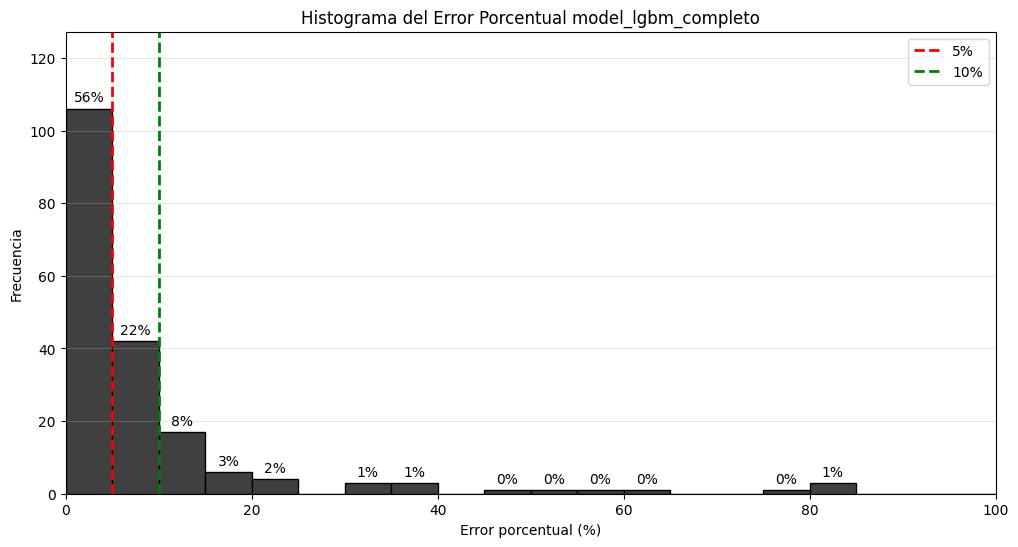

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_completo["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual model_lgbm_completo")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

In [ ]:
extra_cols = ['url']

# Asegurate de que los índices coincidan
X_test = X_test_all_municipios_completo.reset_index(drop=True)
y_test = y_test_all_municipios_completo.reset_index(drop=True)

# Ejecutar la función
results_rf_all_municipios = evaluation_table(
    rf_all_municipios,
    X_test,
    y_test,
    data.iloc[test_indices_all_municipios_completo],
    extra_cols
)
# Ver los primeros resultados
print("RF All Municipios Completo: \n")
results_rf_all_municipios.head(20)

RF All Municipios Completo: 



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"55,000.00","126,252.44","71,252.44",129.55,https://www.casasymas.com.uy/propiedad/120273-...
1,"2,000,000.00","688,249.68","1,311,750.32",65.59,https://www.casasymas.com.uy/propiedad/1322-ca...
2,"305,000.00","146,116.59","158,883.41",52.09,https://www.casasymas.com.uy/propiedad/116984-...
3,"170,000.00","258,149.60","88,149.60",51.85,https://www.casasymas.com.uy/propiedad/207263-...
4,"120,000.00","174,765.09","54,765.09",45.64,https://www.casasymas.com.uy/propiedad/199197-...
5,"157,000.00","218,146.26","61,146.26",38.95,https://www.casasymas.com.uy/propiedad/203188-...
6,"420,000.00","261,634.97","158,365.03",37.71,https://www.casasymas.com.uy/propiedad/38319-c...
7,"128,000.00","173,473.62","45,473.62",35.53,https://www.casasymas.com.uy/propiedad/151589-...
8,"850,000.00","580,719.39","269,280.61",31.68,https://www.casasymas.com.uy/propiedad/65438-c...
9,"175,000.00","120,110.11","54,889.89",31.37,https://www.casasymas.com.uy/propiedad/64480-c...


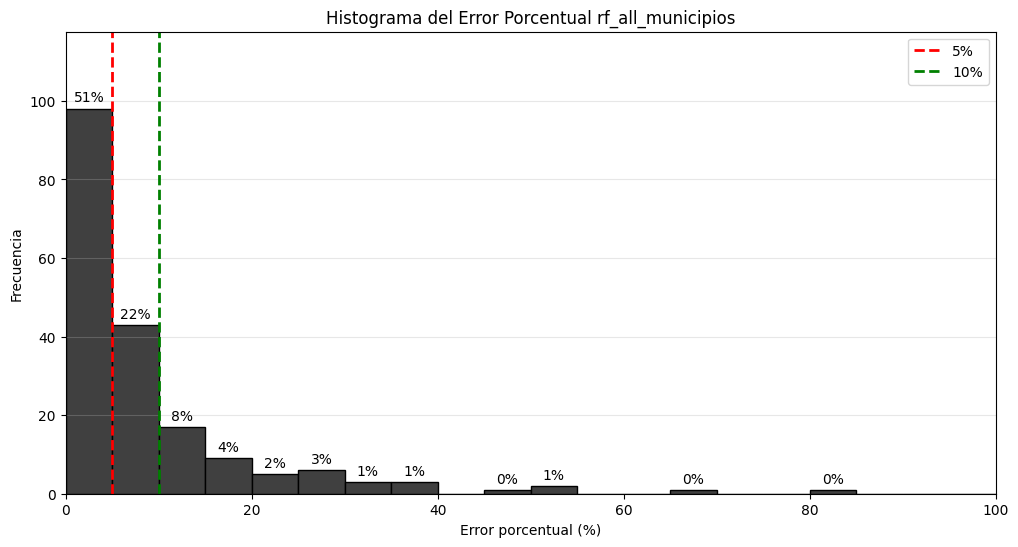

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_rf_all_municipios["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual rf_all_municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

PARA DESPUES

In [ ]:
umbral_10 = 10
umbral_20 = 20
umbral_5 = 5

# Contar
count_below_5 = (results["Error %"] <= umbral_5).sum()
count_below_10 = (results["Error %"] <= umbral_10).sum()
count_above_5 = (results["Error %"] > umbral_5).sum()
count_above_10 = (results["Error %"] > umbral_10).sum()

# Mostrar resultados
print(f"Predicciones con error ≤ {umbral_5}%: {count_below_5}")
print(f"Predicciones con error ≤ {umbral_10}%: {count_below_10}")
print(f"Predicciones con error > {umbral_5}%: {count_above_5}")
print(f"Predicciones con error > {umbral_10}%: {count_above_10}")

# Si querés también el porcentaje respecto al total:
total = len(results)
print("\nPorcentajes:")
print(f"≤ {umbral_5}%: {count_below_5 / total * 100:.2f}%")
print(f"≤ {umbral_10}%: {count_below_10 / total * 100:.2f}%")
print(f"> {umbral_5}%: {count_above_5 / total * 100:.2f}%")
print(f"> {umbral_10}%: {count_above_10 / total * 100:.2f}%")

Predicciones con error ≤ 5%: 98
Predicciones con error ≤ 10%: 141
Predicciones con error > 5%: 91
Predicciones con error > 10%: 48

Porcentajes:
≤ 5%: 51.85%
≤ 10%: 74.60%
> 5%: 48.15%
> 10%: 25.40%


## Exportar modelos con `pickle` y `joblib`

In [ ]:
import pickle
import joblib
import os

# Crear un directorio para guardar los modelos si no existe
output_dir = '/content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models'
os.makedirs(output_dir, exist_ok=True)

# Lista de modelos a exportar y sus nombres
models_to_export = [
    (model_lr_simple, "model_lr_simple"),
    (model_lr, "model_lr"),
    (rf_municipio_ch_simple, "rf_municipio_ch_simple"),
    (rf_municipio_ch, "rf_municipio_ch"),
    (rf_municipio_e_simple, "rf_municipio_e_simple"),
    (rf_municipio_e, "rf_municipio_e"),
    (rf_all_municipios_simple, "rf_all_municipios_simple"),
    (rf_all_municipios, "rf_all_municipios"),
    (rf_gridsearch_municipio_ch_simple, "rf_gridsearch_municipio_ch_simple"),
    (rf_gridsearch_municipio_ch, "rf_gridsearch_municipio_ch"),
    (rf_gridsearch_municipio_e_simple, "rf_gridsearch_municipio_e_simple"),
    (rf_gridsearch_municipio_e, "rf_gridsearch_municipio_e"),
    (rf_gridsearch_all_municipios_simple, "rf_gridsearch_all_municipios_simple"),
    (rf_gridsearch_all_municipios, "rf_gridsearch_all_municipios"),
]

for model, name in models_to_export:
    # Exportar con pickle
    pickle_filename = os.path.join(output_dir, f"{name}.pkl")
    with open(pickle_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Exportado {name} con pickle a: {pickle_filename}")

    # Exportar con joblib
    joblib_filename = os.path.join(output_dir, f"{name}.joblib")
    joblib.dump(model, joblib_filename)
    print(f"Exportado {name} con joblib a: {joblib_filename}")

Exportado model_lr_simple con pickle a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/model_lr_simple.pkl
Exportado model_lr_simple con joblib a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/model_lr_simple.joblib
Exportado model_lr con pickle a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/model_lr.pkl
Exportado model_lr con joblib a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/model_lr.joblib
Exportado rf_municipio_ch_simple con pickle a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/rf_municipio_ch_simple.pkl
Exportado rf_municipio_ch_simple con joblib a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/rf_municipio_ch_simple.joblib
Exportado rf_municipio_ch con pickle a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/rf_municipio_ch.pkl
Exportado rf_municipio_ch con joblib a: /content/drive/MyDrive/MaestriaDataScience/Tesis/exported_models/rf_municipi